In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
import os

print(torch.__version__)

2.5.1


In [2]:
if torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device : {device}")

Using device : mps


In [3]:
#To define data set path
train_dir = "CustomDataSet/data/train"
test_dir = "CustomDataSet/data/test"

In [4]:
#Define train and test transform 
train_transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomGrayscale(p=0.1),
        transforms.GaussianBlur(kernel_size=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #To noramalize using mean and standarddaviation
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [5]:
#Load datasets
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [6]:
#Create Dataloaders for batch
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
from model import CustomCNN


In [8]:
model0 = CustomCNN(num_classes=4)
model0.to(device=device)

/opt/anaconda3/envs/AI3/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/AI3/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/hoatran/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.2MB/s]


CustomCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [13]:
class_names = train_data.classes
print(class_names)

['donuts', 'french_fries', 'fried_rice', 'samosa']


In [10]:
# to view class as dict
class_dict = train_data.class_to_idx
class_dict

{'donuts': 0, 'french_fries': 1, 'fried_rice': 2, 'samosa': 3}

In [11]:
len(train_data), len(test_data)

(1834, 608)

In [12]:
from torchinfo import summary

summary(
    model= model0,
    input_size=(32,3,256,256),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
CustomCNN (CustomCNN)                         [32, 3, 256, 256]    [32, 4]              388,416              True
├─Sequential (feature_extractor)              [32, 3, 256, 256]    [32, 512, 1, 1]      --                   True
│    └─Conv2d (0)                             [32, 3, 256, 256]    [32, 64, 128, 128]   9,408                True
│    └─BatchNorm2d (1)                        [32, 64, 128, 128]   [32, 64, 128, 128]   128                  True
│    └─ReLU (2)                               [32, 64, 128, 128]   [32, 64, 128, 128]   --                   --
│    └─MaxPool2d (3)                          [32, 64, 128, 128]   [32, 64, 64, 64]     --                   --
│    └─Sequential (4)                         [32, 64, 64, 64]     [32, 64, 64, 64]     --                   True
│    │    └─BasicBlock (0)                    [32, 64, 64, 64]     [32, 64, 64, 64]    

In [14]:
#setup loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model0.parameters(), 
    lr=0.0001,
    weight_decay=1e-4
)


In [15]:
from trainNN import train

/opt/anaconda3/envs/AI3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
star_time = timer()

results = train(
    model=model0,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=30,
    device=device
)
end_time = timer()

print(f"[INFO] Total training time : {end_time-star_time:.3f} seconds")

  3%|▎         | 1/30 [00:35<17:06, 35.39s/it]

Epoch: 1 | train_loss: 0.5203 | train_acc: 0.8269 | test_loss: 0.1294 | test_acc: 0.9622


  7%|▋         | 2/30 [01:04<14:43, 31.54s/it]

Epoch: 2 | train_loss: 0.2258 | train_acc: 0.9256 | test_loss: 0.1422 | test_acc: 0.9638


 10%|█         | 3/30 [01:33<13:38, 30.32s/it]

Epoch: 3 | train_loss: 0.1154 | train_acc: 0.9644 | test_loss: 0.1050 | test_acc: 0.9589


 13%|█▎        | 4/30 [02:01<12:52, 29.71s/it]

Epoch: 4 | train_loss: 0.1055 | train_acc: 0.9621 | test_loss: 0.1264 | test_acc: 0.9539


 17%|█▋        | 5/30 [02:30<12:12, 29.30s/it]

Epoch: 5 | train_loss: 0.1205 | train_acc: 0.9585 | test_loss: 0.1200 | test_acc: 0.9572


 20%|██        | 6/30 [02:59<11:38, 29.11s/it]

Epoch: 6 | train_loss: 0.0707 | train_acc: 0.9774 | test_loss: 0.0861 | test_acc: 0.9737


 23%|██▎       | 7/30 [03:27<11:06, 28.96s/it]

Epoch: 7 | train_loss: 0.0483 | train_acc: 0.9849 | test_loss: 0.0994 | test_acc: 0.9688


 27%|██▋       | 8/30 [03:56<10:35, 28.88s/it]

Epoch: 8 | train_loss: 0.0642 | train_acc: 0.9811 | test_loss: 0.0860 | test_acc: 0.9753


 30%|███       | 9/30 [04:25<10:06, 28.90s/it]

Epoch: 9 | train_loss: 0.0433 | train_acc: 0.9881 | test_loss: 0.1417 | test_acc: 0.9655


 33%|███▎      | 10/30 [04:54<09:37, 28.86s/it]

Epoch: 10 | train_loss: 0.0555 | train_acc: 0.9811 | test_loss: 0.1408 | test_acc: 0.9605


 37%|███▋      | 11/30 [05:23<09:08, 28.86s/it]

Epoch: 11 | train_loss: 0.0397 | train_acc: 0.9855 | test_loss: 0.1405 | test_acc: 0.9638


 40%|████      | 12/30 [05:52<08:40, 28.93s/it]

Epoch: 12 | train_loss: 0.0404 | train_acc: 0.9876 | test_loss: 0.1221 | test_acc: 0.9622


 43%|████▎     | 13/30 [06:21<08:11, 28.93s/it]

Epoch: 13 | train_loss: 0.0476 | train_acc: 0.9844 | test_loss: 0.1068 | test_acc: 0.9720


 47%|████▋     | 14/30 [06:50<07:43, 28.97s/it]

Epoch: 14 | train_loss: 0.0405 | train_acc: 0.9897 | test_loss: 0.1406 | test_acc: 0.9474


 50%|█████     | 15/30 [07:19<07:14, 28.98s/it]

Epoch: 15 | train_loss: 0.0395 | train_acc: 0.9855 | test_loss: 0.1641 | test_acc: 0.9523


 53%|█████▎    | 16/30 [07:48<06:46, 29.00s/it]

Epoch: 16 | train_loss: 0.0407 | train_acc: 0.9876 | test_loss: 0.1424 | test_acc: 0.9638


 57%|█████▋    | 17/30 [08:17<06:17, 29.01s/it]

Epoch: 17 | train_loss: 0.0262 | train_acc: 0.9919 | test_loss: 0.1262 | test_acc: 0.9622


 60%|██████    | 18/30 [08:46<05:48, 29.02s/it]

Epoch: 18 | train_loss: 0.0349 | train_acc: 0.9892 | test_loss: 0.1242 | test_acc: 0.9770


 63%|██████▎   | 19/30 [09:15<05:19, 29.02s/it]

Epoch: 19 | train_loss: 0.0359 | train_acc: 0.9881 | test_loss: 0.1086 | test_acc: 0.9655


 67%|██████▋   | 20/30 [09:44<04:50, 29.02s/it]

Epoch: 20 | train_loss: 0.0293 | train_acc: 0.9898 | test_loss: 0.0971 | test_acc: 0.9786


 70%|███████   | 21/30 [10:13<04:21, 29.03s/it]

Epoch: 21 | train_loss: 0.0205 | train_acc: 0.9935 | test_loss: 0.1045 | test_acc: 0.9720


 73%|███████▎  | 22/30 [10:42<03:52, 29.01s/it]

Epoch: 22 | train_loss: 0.0287 | train_acc: 0.9914 | test_loss: 0.0871 | test_acc: 0.9720


 77%|███████▋  | 23/30 [11:11<03:23, 29.06s/it]

Epoch: 23 | train_loss: 0.0199 | train_acc: 0.9925 | test_loss: 0.0864 | test_acc: 0.9753


 80%|████████  | 24/30 [11:40<02:54, 29.05s/it]

Epoch: 24 | train_loss: 0.0194 | train_acc: 0.9930 | test_loss: 0.1257 | test_acc: 0.9671


 83%|████████▎ | 25/30 [12:09<02:25, 29.05s/it]

Epoch: 25 | train_loss: 0.0478 | train_acc: 0.9849 | test_loss: 0.0921 | test_acc: 0.9688


 87%|████████▋ | 26/30 [12:38<01:56, 29.06s/it]

Epoch: 26 | train_loss: 0.0381 | train_acc: 0.9844 | test_loss: 0.1212 | test_acc: 0.9655


 90%|█████████ | 27/30 [13:07<01:27, 29.08s/it]

Epoch: 27 | train_loss: 0.0281 | train_acc: 0.9903 | test_loss: 0.1130 | test_acc: 0.9753


 93%|█████████▎| 28/30 [13:36<00:58, 29.08s/it]

Epoch: 28 | train_loss: 0.0243 | train_acc: 0.9941 | test_loss: 0.1628 | test_acc: 0.9622


 97%|█████████▋| 29/30 [14:06<00:29, 29.10s/it]

Epoch: 29 | train_loss: 0.0340 | train_acc: 0.9919 | test_loss: 0.1042 | test_acc: 0.9638


100%|██████████| 30/30 [14:34<00:00, 29.17s/it]

Epoch: 30 | train_loss: 0.0478 | train_acc: 0.9787 | test_loss: 0.1040 | test_acc: 0.9737
[INFO] Total training time : 875.023 seconds


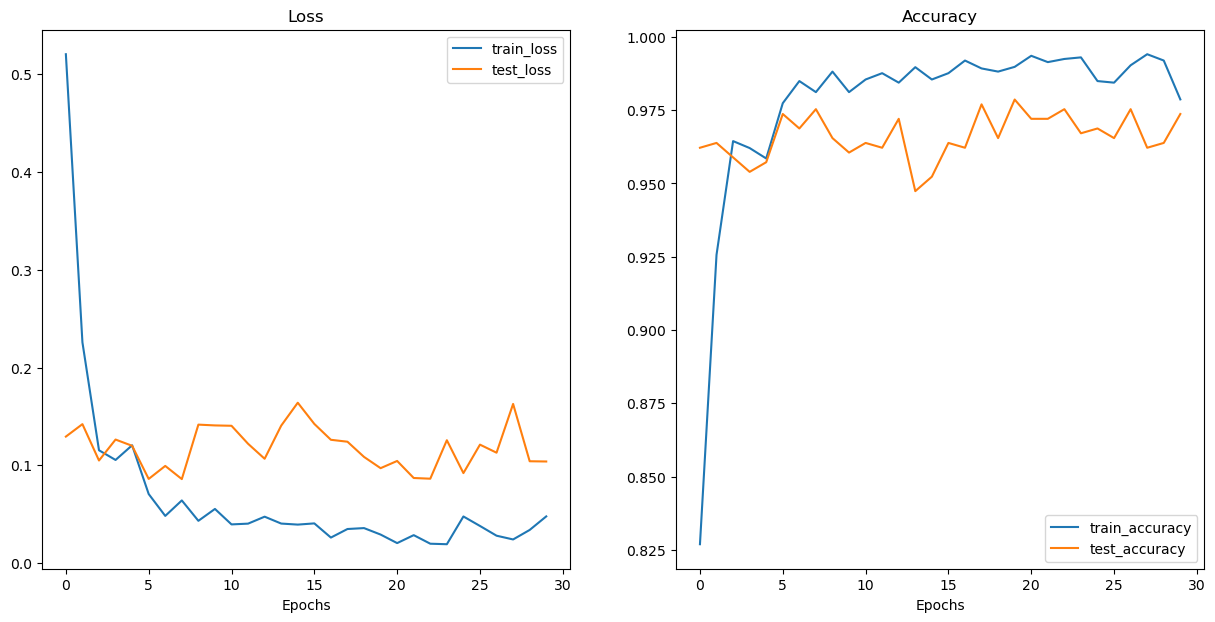

In [17]:
from helper_functions import plot_loss_curves
plot_loss_curves(results=results)

In [ ]:
#it shows the model is overfitted

In [19]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "modelv2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model0.state_dict(), f = MODEL_SAVE_PATH)

Saving model to models/modelv2.pth
